In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import pickle as pkl
import sys
blocking_dir='/storage1/thomasen/software/BLOCKING_OLD/MonoCV'
sys.path.append(blocking_dir)
import block as block

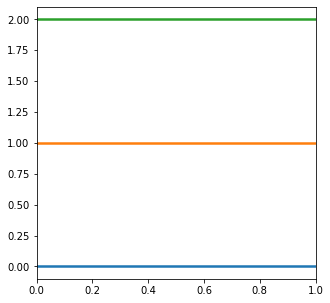

In [7]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#new_cmap = ['#1F78B4','#FB9A99','#E31A1C']
new_cmap = ['tab:blue','tab:orange','tab:green']
rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,3))

#Test colormap
fig = plt.figure(figsize=(5,5))

for i,color in enumerate(colors):
    plt.axhline(i, color=colors[i], linewidth=2.5)

In [21]:
systems = ['2PHES_150mMNaCl', 'TYR_PHE_150mMNaCl', '2TYRS_150mMNaCl', 'BUTYLAMMONIUM_ACETATE', 'GUANIDINE_ACETATE']
ffmods = ['Unmodified', 'PW', 'PP']

systems_plotname_alt = {'2PHES_150mMNaCl':'Phe-Phe',
                    'TYR_PHE_150mMNaCl':'Tyr-Phe',
                    '2TYRS_150mMNaCl':'Tyr-Tyr',
                    'BUTYLAMMONIUM_ACETATE':'Butylammonium-Acetate',
                    'GUANIDINE_ACETATE':'Guanidine-Acetate'}

systems_plotname = {'2PHES_150mMNaCl':'Phe-Phe',
                    'TYR_PHE_150mMNaCl':'Tyr-Phe',
                    '2TYRS_150mMNaCl':'Tyr-Tyr',
                    'BUTYLAMMONIUM_ACETATE':'Lys-Asp',
                    'GUANIDINE_ACETATE':'Arg-Asp'}

bound_cutoff = 0.8
recalculate = False

In [9]:
#Functions for saving and loading pickle files
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

In [10]:
if recalculate == True:

    for system in systems:
        fraction_bound_vs_sim = {}
        for i,ffmod in enumerate(ffmods):
            print(f'Starting {system} {ffmod}')

            time, mindist = np.genfromtxt(f'data/mindist_{system}_{ffmod}.xvg', skip_header=24, usecols=(0,1), unpack=True)
            print('Loaded data')

            #Get fraction bound average and block error
            bound_vs_time = mindist < bound_cutoff
            frames_bound = np.average(bound_vs_time)
            blocks_stat = block.blocking(bound_vs_time)
            corr_len, err = block.optimal_block(len(bound_vs_time),blocks_stat,method='hline')

            fraction_bound_vs_sim[f'{system}_{ffmod}'] = [frames_bound, err]

        save_pickle(f'pickles/fractions_bound_mindist_{system}.pkl', fraction_bound_vs_sim)

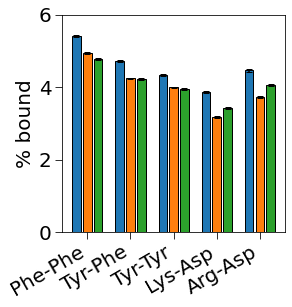

In [11]:
#Plot data
fig= plt.figure(figsize=(4,4))

xtick_labels=[]
for i,system in enumerate(systems):
    fraction_bound_vs_sim = load_pickle(f'pickles/fractions_bound_mindist_{system}.pkl')
    xaxis = [i-0.25, i, i+0.25]

    for j,ffmod in enumerate(ffmods):
        fraction_bound = fraction_bound_vs_sim[f'{system}_{ffmod}'][0]
        fraction_bound_err = fraction_bound_vs_sim[f'{system}_{ffmod}'][1]
        plt.bar(xaxis[j], fraction_bound*100, yerr=fraction_bound_err*100, color=colors[j], width=0.2, edgecolor='black', capsize=3.0)
    
    xtick_labels.append(systems_plotname[system])

plt.ylim(0,6)
plt.ylabel('% bound', fontsize=20)

plt.tick_params(colors='black', direction='out', length=7, labelsize=20)
plt.xticks(range(len(systems)), labels=xtick_labels, rotation=30, fontsize=20, ha='right')

# Experimental Ka for Lys-Asp and Arg-Asp

In [17]:
#From Spriggs and Haake 1977
#and Christian and Tucker 1982
Kd_exp = {
    'BUTYLAMMONIUM_ACETATE':(1.0/0.31),
    'GUANIDINE_ACETATE':(1.0/0.37),
    '2PHES_150mMNaCl':(1.0/0.40),
    'TYR_PHE_150mMNaCl':(1.0/0.60)

}
systems_expt = Kd_exp.keys()

In [18]:
if recalculate == True:

    real_fraction_bound_vs_system = {}
    for system in systems_expt:
        print(system)
        avg_volume = 0
        for i,ffmod in enumerate(ffmods):
            print(ffmod)
            volume = np.genfromtxt(f'data/pVTE_{system}_{ffmod}.xvg', skip_header=27, usecols=4, unpack=True)
            avg_volume += np.average(volume)

        avg_volume /= len(ffmods)
        avogadros = 6.022*(10**23)
        vol_liters = avg_volume*((10**-9)**3)*(10**3)

        conc = ((2/avogadros)/vol_liters) #2 for two copies of the protein
        real_fraction_bound = (4*conc + Kd_exp[system] - np.sqrt(8*Kd_exp[system]*conc + np.square(Kd_exp[system])))/(4*conc)
        
        real_fraction_bound_vs_system[f'{system}_conc'] = conc
        real_fraction_bound_vs_system[system] = real_fraction_bound

    save_pickle(f'pickles/real_fraction_bound_vs_system.pkl', real_fraction_bound_vs_system)

BUTYLAMMONIUM_ACETATE
Unmodified
PW
PP
GUANIDINE_ACETATE
Unmodified
PW
PP
2PHES_150mMNaCl
Unmodified
PW
PP
TYR_PHE_150mMNaCl
Unmodified
PW
PP


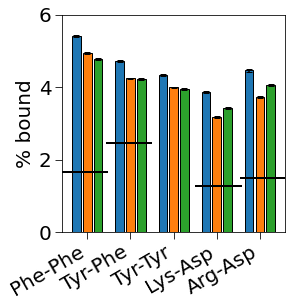

In [25]:
real_fraction_bound_vs_system = load_pickle(f'pickles/real_fraction_bound_vs_system.pkl')

#Plot data
fig = plt.figure(figsize=(4,4))

xtick_labels=[]
for i,system in enumerate(systems):
    fraction_bound_vs_sim = load_pickle(f'pickles/fractions_bound_mindist_{system}.pkl')
    xaxis = [i-0.25, i, i+0.25]

    for j,ffmod in enumerate(ffmods):
        fraction_bound = fraction_bound_vs_sim[f'{system}_{ffmod}'][0]
        fraction_bound_err = fraction_bound_vs_sim[f'{system}_{ffmod}'][1]
        plt.bar(xaxis[j], fraction_bound*100, yerr=fraction_bound_err*100, color=colors[j], width=0.2, edgecolor='black', capsize=3.0)
    if system in systems_expt:
        plt.axhline(y=real_fraction_bound_vs_system[system]*100, xmin=(i/len(systems)), xmax=((i+1)/len(systems)), c='black', lw=2)
        #plt.axhline(y=real_fraction_bound_vs_system[system]*100, ls='--', c='black', lw=2)
   
    xtick_labels.append(systems_plotname[system])

plt.ylim(0,6)
plt.ylabel('% bound', fontsize=20)

plt.tick_params(colors='black', direction='out', length=7, labelsize=20)
plt.xticks(range(len(systems)), labels=xtick_labels, rotation=30, fontsize=20, ha='right')

fig.savefig(f"../figures/sidechainanalogues_fractionbound_vs_lambda.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig(f"../figures/sidechainanalogues_fractionbound_vs_lambda.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

In [20]:
print(real_fraction_bound_vs_system)

{'BUTYLAMMONIUM_ACETATE_conc': 0.02092977437136943, 'BUTYLAMMONIUM_ACETATE': 0.012650226393793257, 'GUANIDINE_ACETATE_conc': 0.020826832381045476, 'GUANIDINE_ACETATE': 0.014954353861487416, '2PHES_150mMNaCl_conc': 0.02156207070235736, '2PHES_150mMNaCl': 0.016679039832441928, 'TYR_PHE_150mMNaCl_conc': 0.02163244498851071, 'TYR_PHE_150mMNaCl': 0.02469276622069545}
